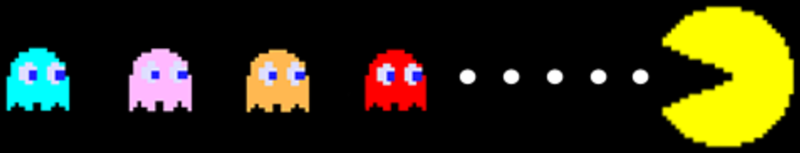

# Find PacMan and the ghost

- Task: use particle filter to determine the location of the PacMan and the ghost
  - Use two sets of particles, one for the PacMan and one for the ghost
  - The PacMan can sense its location using environment landmarks
  - The PacMan can sense its distance to the ghost
    - In the code below, this is simulated as a "sense" function in the "ghost" class

- You only have to code the downweight and resample steps, everything else is given
- Answer this question in a text cell:
  - What has to happen for the particle filter method to reduce the uncertainty about the ghost location?
    - The images below are in decreasing order of uncertainty

- Submission format:
  - submit one .ipynb file (File->Download->Download .ipynb) to Canvas

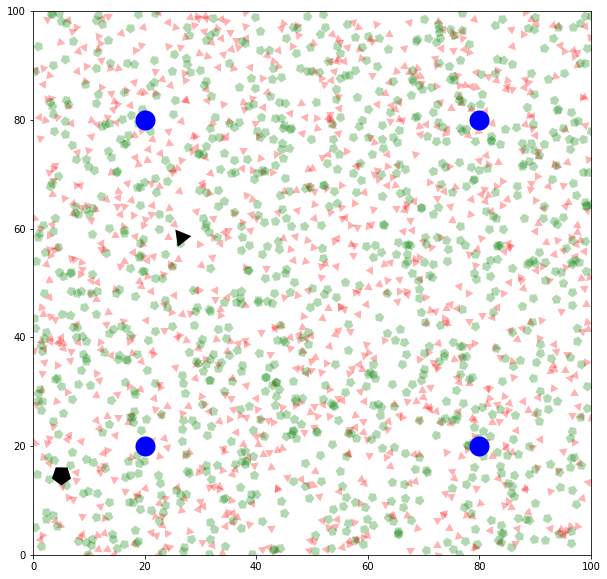

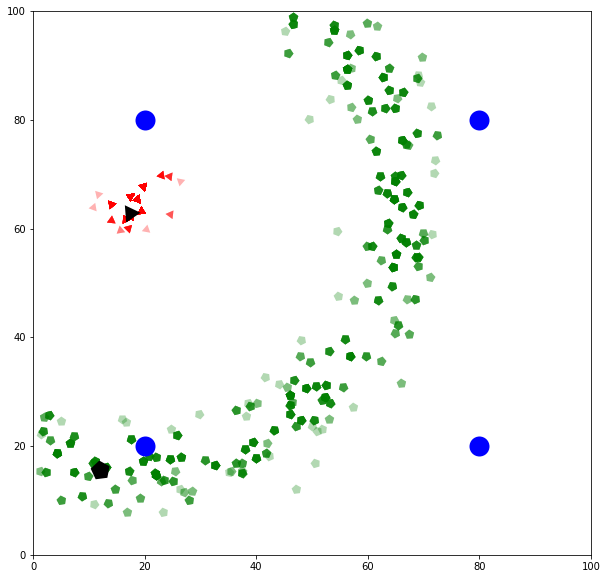

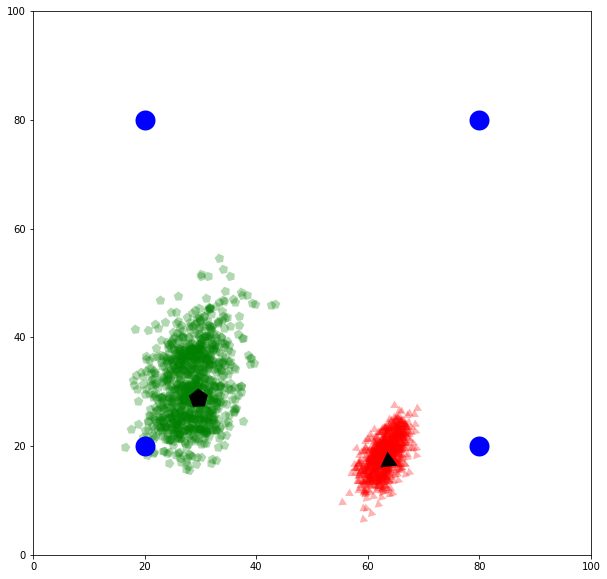

In [2]:
from math import *
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0

class robot:
    def __init__(self):
        # initialise with random
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
 
        self.forward_noise = 0.0
        self.turn_noise    = 0.0
        self.sense_noise   = 0.0

    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)

    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);

    def new_position(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (cos(orientation) * dist)
        y = self.y + (sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size

        return x, y, orientation

    def Gaussian(self, mu, sigma, x):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))

    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))

# PacMan class
class pacman(robot):
    # the PacMan can sense its location using the landmarks
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z

    # calculates how likely a measurement should be
    def measurement_prob(self, measurement):
        prob = 1.0
        for i in range(len(landmarks)):
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob

    def move(self, turn, forward):
        x, y, orientation = self.new_position(turn, forward)
        res = pacman()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res

# Ghost class
class ghost(robot):
    # the PacMan ("mypacman") can sense its distance to the ghost
    def sense(self, mypacman):
        Z = sqrt((self.x - mypacman.x) ** 2 + (self.y - mypacman.y) ** 2) + random.gauss(0.0, self.sense_noise)
        return Z

    # calculates how likely a measurement should be
    def measurement_prob(self, measurement, mypacman):
        dist = sqrt((self.x - mypacman.x) ** 2 + (self.y - mypacman.y) ** 2)
        prob = self.Gaussian(dist, self.sense_noise, measurement)
        return prob

    def move(self, turn, forward):
        x, y, orientation = self.new_position(turn, forward)
        res = ghost()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res

def eval(r, p):
    s = 0.0;
    for i in range(len(p)): # calculate mean error
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = sqrt(dx * dx + dy * dy)
        s += err
    return s / float(len(p))

In [4]:
# PacMan is a triangle, ghost is a pentagon, landmarks are circles
def show_belief(pacman, pacman_particles, ghost, ghost_particles):
  plt.rcParams["figure.figsize"] = (10,10)

  for p in pacman_particles:
    plt.plot(p.x, p.y, marker=(3, 0, 180.0*p.orientation/pi), markerfacecolor='red', markersize=10, markeredgewidth=0.0, alpha=.3, linestyle='None')

  for p in ghost_particles:
    plt.plot(p.x, p.y, marker=(5, 0, 180.0*p.orientation/pi), markerfacecolor='green', markersize=10, markeredgewidth=0.0, alpha=.3, linestyle='None')

  plt.plot(pacman.x, pacman.y, marker=(3, 0, 180.0*pacman.orientation/pi), markerfacecolor='black', markersize=20, markeredgewidth=0.0, linestyle='None')

  plt.plot(ghost.x, ghost.y, marker=(5, 0, 180.0*ghost.orientation/pi), markerfacecolor='black', markersize=20, markeredgewidth=0.0, linestyle='None')

  for x, y in landmarks:
      plt.plot(x, y, marker='o', markerfacecolor='blue', markersize=20, markeredgewidth=0.0, linestyle='None')

  plt.xlim([0,100])
  plt.ylim([0,100])

  plt.show()

In [5]:
forward_noise = 3.0 
turn_noise = 0.05
sense_noise = 3.0  # noise variance

# actual location
mypacman = pacman()
mypacman.set_noise(forward_noise, turn_noise, sense_noise)

myghost = ghost()
myghost.set_noise(forward_noise, turn_noise, sense_noise)

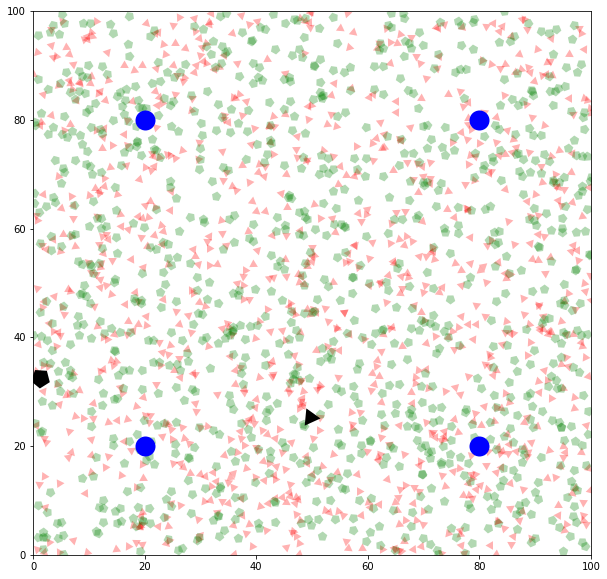

In [6]:
N = 1000 # number of particles
T = 10  # number of moves

# initialise randomly guessed particles for pacman and ghost
p = []
g = []
for i in range(N):
    x = pacman()
    x.set_noise(forward_noise, turn_noise, sense_noise)
    p.append(x)
    x = ghost()
    x.set_noise(forward_noise, turn_noise, sense_noise)
    g.append(x)

show_belief(mypacman, p, myghost, g)

initial pacman err 38.05863526906425
initial ghost err 37.61603621681087
move


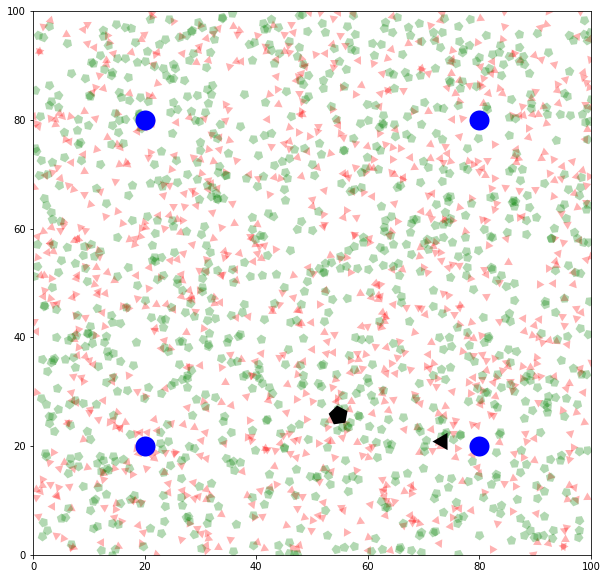

resample


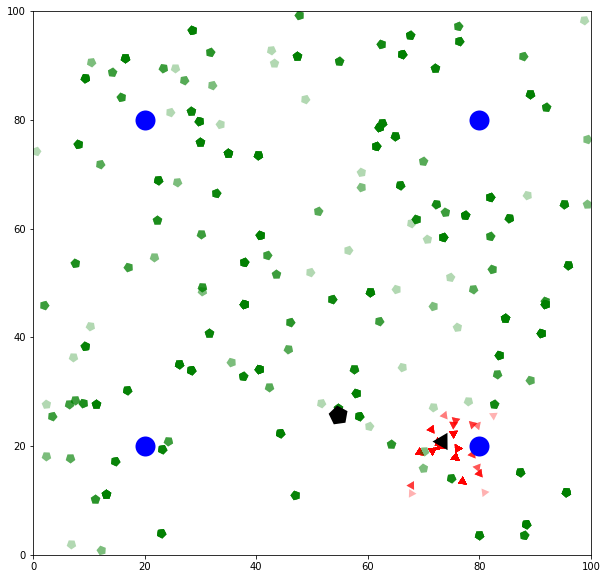

round 0 pacman err 2.876803101843218
round 0 ghost err 38.252996031510044
move


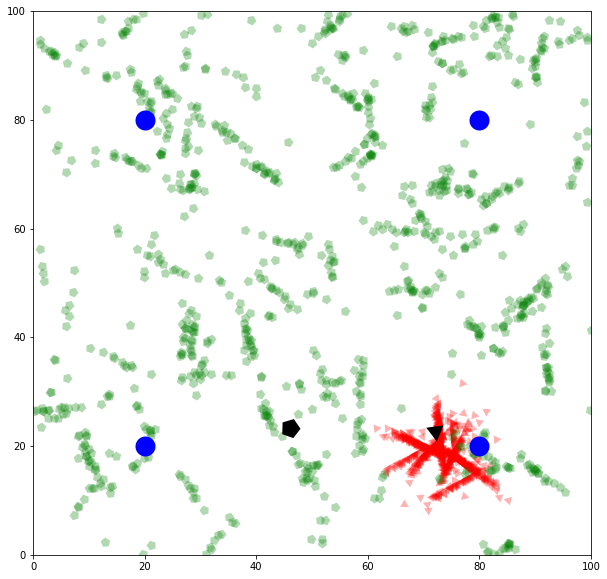

resample


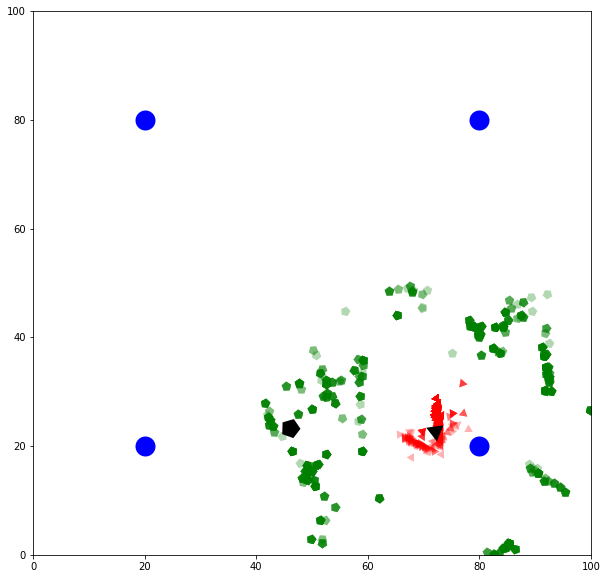

round 1 pacman err 3.1821845729099683
round 1 ghost err 29.084973051666175
move


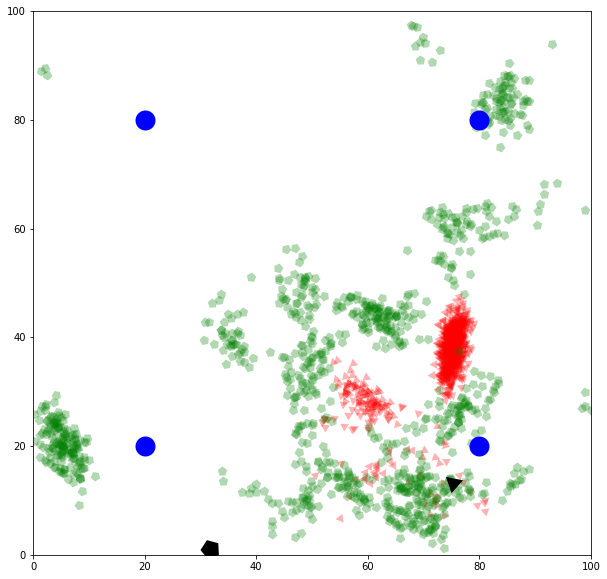

resample


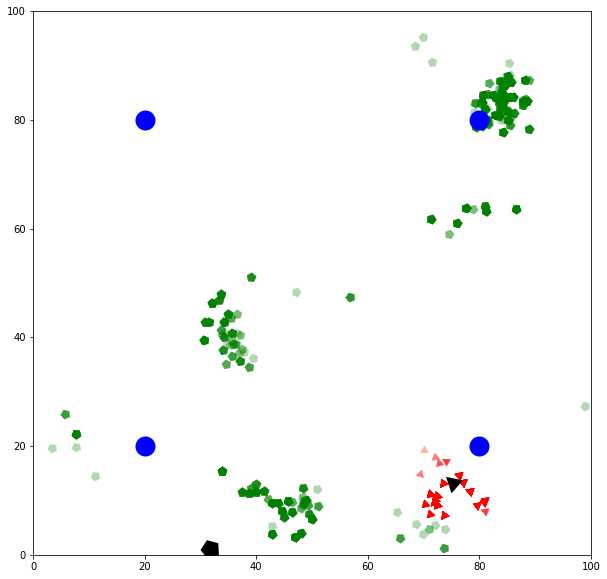

round 2 pacman err 3.8415231954982345
round 2 ghost err 40.392585954671084
move


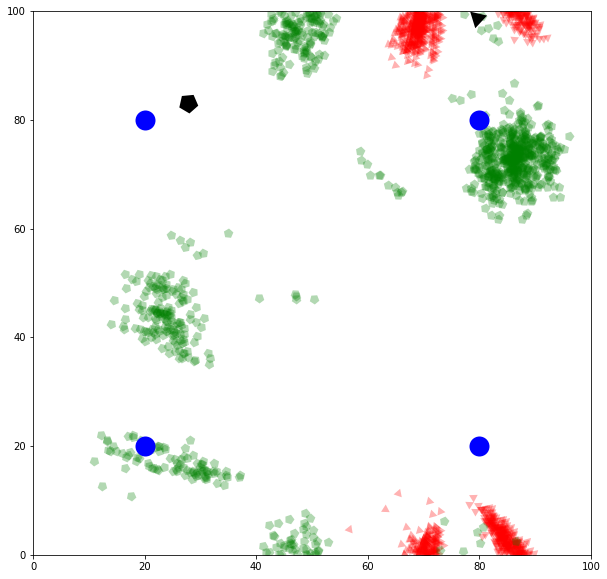

resample


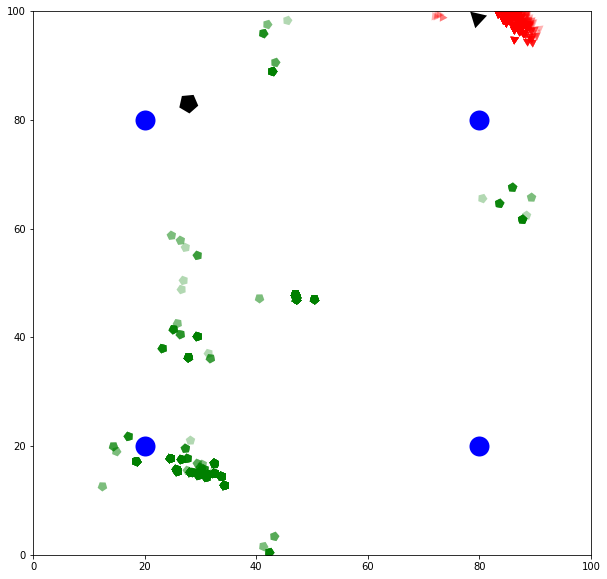

round 3 pacman err 6.611699389687217
round 3 ghost err 35.484722516922105
move


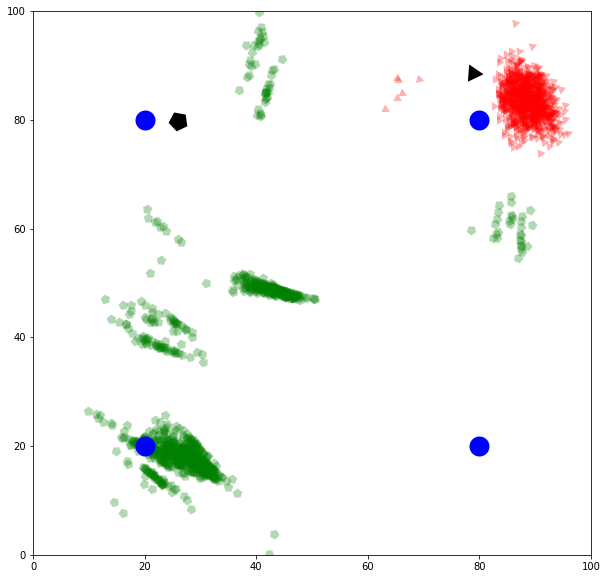

resample


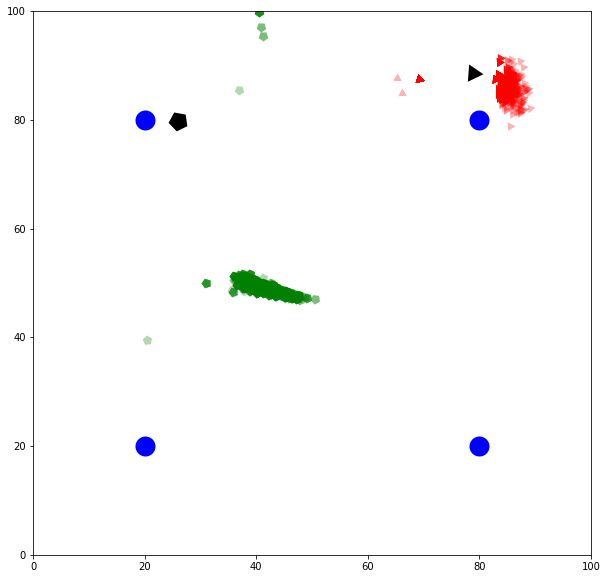

round 4 pacman err 6.8352556479480615
round 4 ghost err 34.77255152807313
move


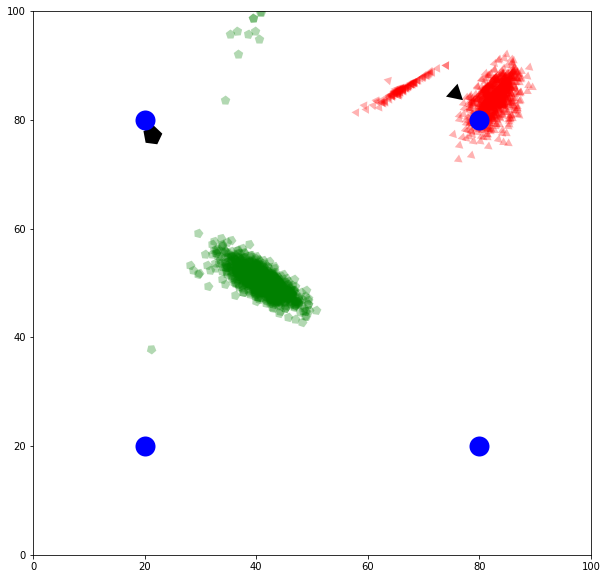

resample


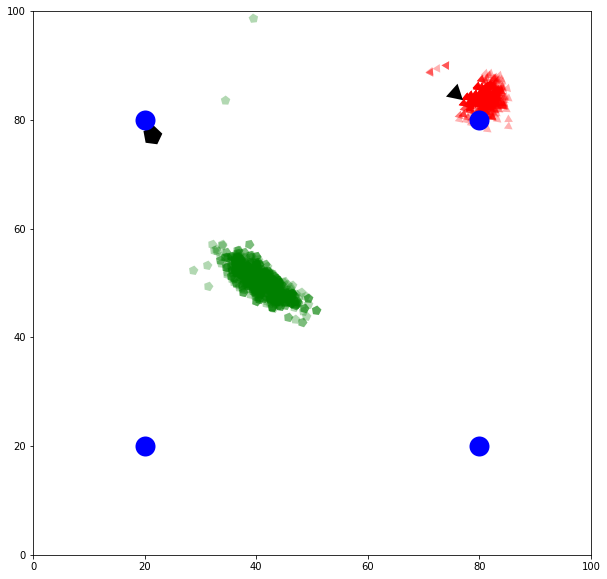

round 5 pacman err 5.517827321197763
round 5 ghost err 33.282867125304016
move


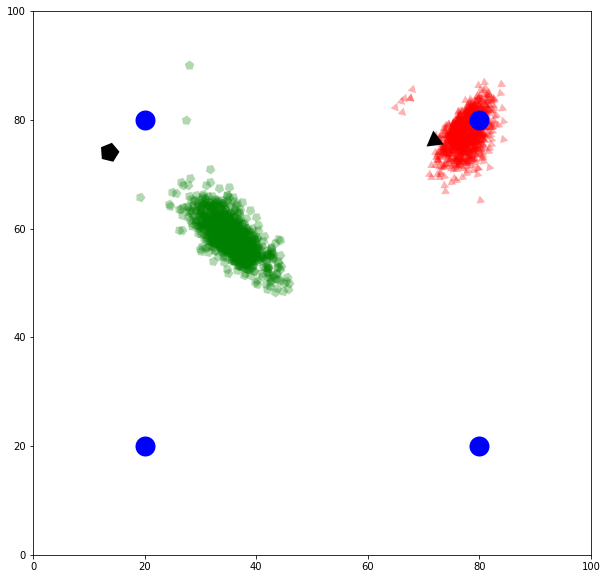

resample


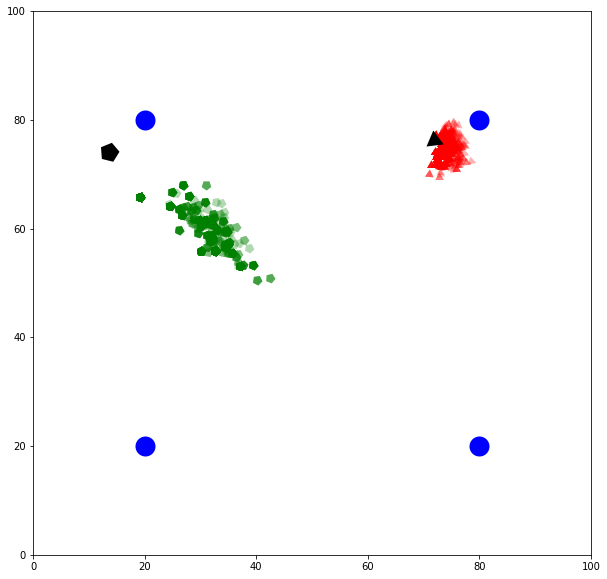

round 6 pacman err 3.082539895346574
round 6 ghost err 22.11615785525968
move


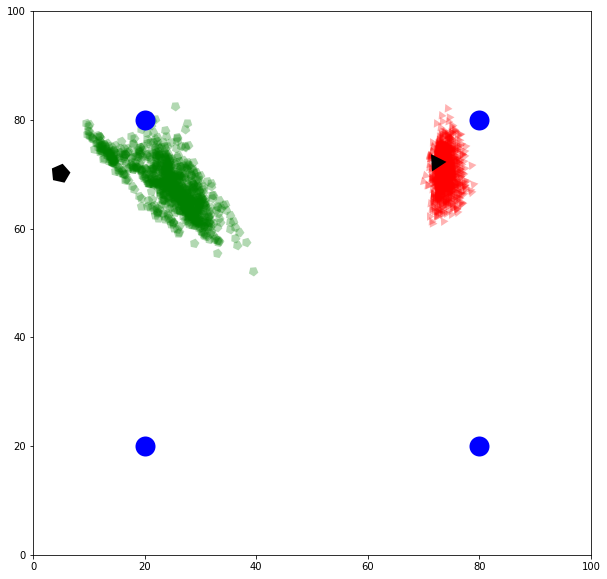

resample


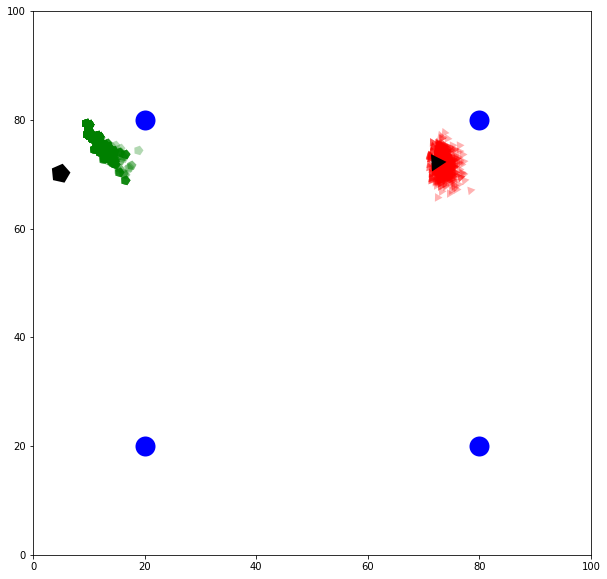

round 7 pacman err 2.139002359115234
round 7 ghost err 9.204907732133554
move


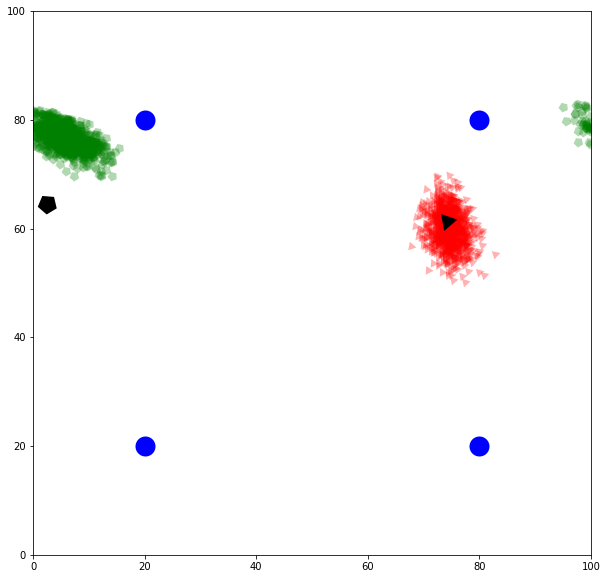

resample


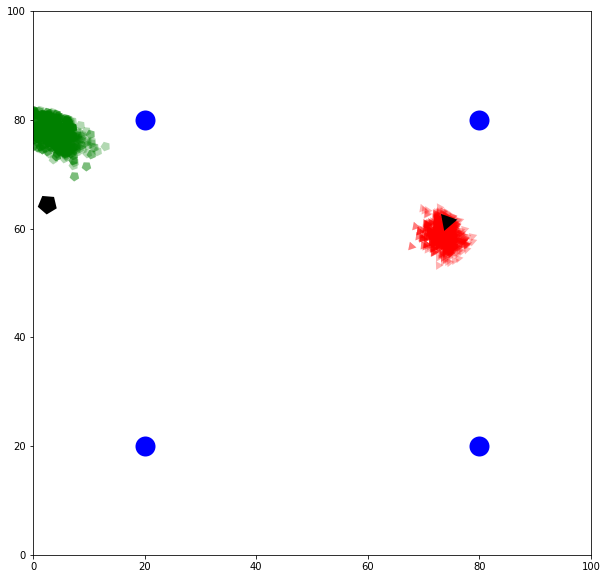

round 8 pacman err 3.2742899461323494
round 8 ghost err 13.372403258528937
move


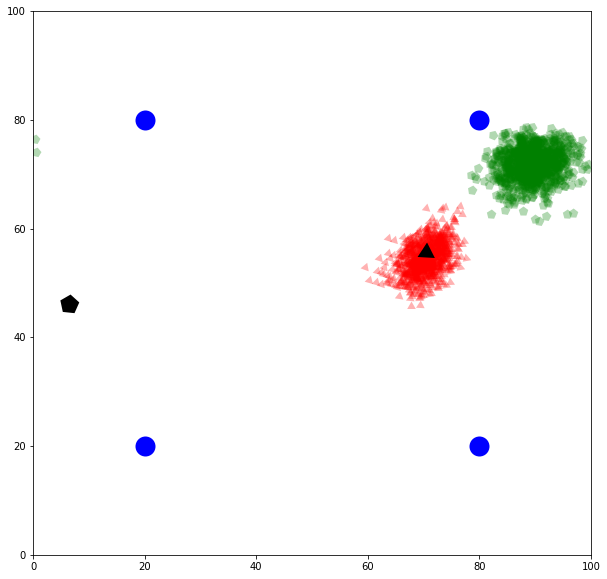

resample


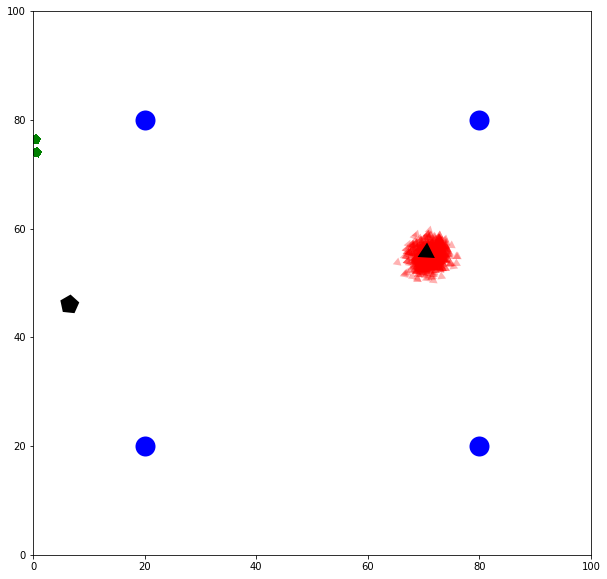

round 9 pacman err 2.185336171141322
round 9 ghost err 30.150470508002957


In [11]:
init_err = eval(mypacman, p)
print("initial pacman err", init_err)
init_err = eval(myghost, g)
print("initial ghost err", init_err)

for rd in range(T):
  # random move for pacman
  pturn = (random.random()-0.5)*(pi/2.0) # random angle in [-45,45]
  pdist = random.random()*20.0           # random distance in [0,20]
  mypacman = mypacman.move(pturn, pdist)

  # random move for ghost
  gturn = (random.random()-0.5)*(pi/2.0) # random angle in [-45,45]
  gdist = random.random()*20.0           # random distance in [0,20]
  myghost = myghost.move(gturn, gdist)

  # elapsed time
  # move particles using the same movement made by robot
  p2 = []
  g2 = []
  for i in range(N):
    p2.append(p[i].move(pturn, pdist))
    g2.append(g[i].move(gturn, gdist))
  p = p2
  g = g2

  print('move')
  show_belief(mypacman, p, myghost, g)

  # observe
  ZP = mypacman.sense()        # noisy measurement of the distance between the pacman and the landmarks
  ZG = myghost.sense(mypacman) # noisy measurement of the distance between the pacman and the ghost

  # downweight and resample pacman and ghost particles here - check Lecture 11 for an example

  # remember that particles do not know the real location of the PacMan and the ghost, so you cannot access "mypacman" and "myghost" in here
    
  # you should use the obtained measurements from the sensors to update the particles
  # - ZP contains the observed distances between the PacMan and the landmarks
  # - ZG is the observed distance between the PacMan and the ghost

  wp = []
  wg = []
    
  for pac in p:
    prob = pac.measurement_prob(ZP) 
    wp.append(prob)
  
  for i in range(len(g)):
    gho = g[i]
    prob = gho.measurement_prob(ZG, p[i]) 
    wg.append(prob)
    
  p3 = []
  g3 = []
    
  index = int(random.random()*N)
  beta = 0
  mwp = max(wp)

  for i in range(N):
    beta += random.random() * 2 * mwp
    while beta > wp[index]:
      beta -= wp[index]
      index = (index + 1)%N
    p3.append(p[index])

  index = int(random.random()*N)
  beta = 0
  mwg = max(wg)
  for i in range(N):
    beta += random.random() * 2 * mwg
    while beta > wg[index]:
      beta -= wg[index]
      index = (index + 1)%N
    g3.append(g[index])
    
  p = p3
  g = g3

  print('resample')
  show_belief(mypacman, p, myghost, g)

  # calculate err
  err = eval(mypacman, p)
  print("round {} pacman err {}".format(rd, err))
  err = eval(myghost, g)
  print("round {} ghost err {}".format(rd, err))

###### What has to happen for the particle filter method to reduce the uncertainty about the ghost location?
Particle weight adjustment has to be used when the noise is so large that it affects the particle filter prediction. The impact of the noise can first be evaluated and then the original particle weight replaced by the exponential weight for particles when the number of particles reaches a certain proportion. This weight adjustment ensures optimal  operation of the particle filter method.